# What is Transfer Learning?
Transfer learning is a machine learning method where a model trained for a particular task can be used as a starting point for a model to perform a different task.  

In transfer learning, we first train a base network on a base dataset and task, and then we repurpose the learned features, or transfer them, to a second target network to be trained on a target dataset and task. This process will tend to work if the features are general, meaning suitable to both base and target tasks, instead of specific to the base task.  

It is a popular approach in deep learning where pre-trained models are used as the starting point on computer vision and natural language processing tasks given the vast compute and time resources required to develop neural network models on these problems and from the huge jumps in skill that they provide on related problems.  

It is essentially important in case of deep learning because Deep Neural Networks require quite a large amount of data to perform exceptionally well and that comes with a large overhead of data storage and time required to perform such training every single time. So, it is not always feasible because of various reasons like data size or time overhead or hardware resource limitations etc. The alternative is, the model is trained on a huge dataset but only ONCE. Then those weights are saved for that particular NN graph architecture and can be called back as an initialization to perform a different task.  

![](https://www.topbots.com/wp-content/uploads/2019/12/cover_transfer_learning_1600px_web.jpg)
Image Source:- https://www.topbots.com/wp-content/uploads/2019/12/cover_transfer_learning_1600px_web.jpg

Because of the pre-trained weights in case of CNN, the model has already "learnt" to extract basic features like edges, shapes, etc which can be used to further fine tune the NN to the exact purpose we need to use it for.  

These weights and popular architectures are often available Open-Source. These can be found out in the transfer-learning framework of all major software available.  

# Pytorch
![](https://biii.eu/sites/default/files/2019-03/PyTorch-logo.jpg)  
Image Source:- https://biii.eu/sites/default/files/2019-03/PyTorch-logo.jpg200/1*4br4WmxNo0jkcsY796jGDQ.jpeg

PyTorch is an optimized tensor library for deep learning using GPUs and CPUs.  

We are going to use Pytorch here because of it's extensive transfer learning module and easy implementation. It is especially popular because it provides an easy and intuitive implementation of DNN in a more pythonic fashion as compared to any other architectures. The syntax resembles closely with Numpy, thus it is also well suited to be used by beginners and get up to speed with implementing the latest SOTA DNN architectures pretty easily and quickly.  

It also proritizes thinking abour models and algorithms rather than worrying about their syntax. Pytorch has full compatibility with CPU, GPU and TPU.

# Problem Statement
This is a fun dataset where we get to see real world use of Deep Neural Networks. We are going to use deep learning to classify the type of disease a paady crop has, given an image. There are multiple diseases so this is going to be a multi class classification problem.  
Here we are going to learn how to leverage transfer learning though the Pytorch library to perform this classification.

## Dataset Description
The dataset contains a training dataset of 10,407 (75%) labeled paddy leaf images across ten classes (nine diseases and normal leaf). Also provided are additional metadata for each image, such as the paddy variety and age. Your task is to develop an accurate disease classification model using the training dataset and then classify each sample in the test dataset of 3,469 (25%) paddy leaf images into one of the nine diseases or normal leaf. 

As per the competition guidelines, we will use **Accuracy** as the performance metric in this notebook. However we will also track other metrics while training just to ensure that the model generalizes well.

# About this Notebook
This notebook is intended for guiding beginners through the ropes of Transfer Learning and creating basic Pytorch DNN models, so it will be completely beginner friendly. I will try to explain all concepts I am using in this notebook, but it surely requires some basic understanding of Python, Neural Networks, CNN algorithms and Pytorch syntaxes.  

With this in mind, let's get started...

# Get GPU Info

In [1]:
!nvidia-smi

Mon May 16 18:12:54 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Imports

In [2]:
import sys
sys.path.append('../input/pytorch-image-models/pytorch-image-models-master')

In [3]:
# Asthetics
import warnings
import sklearn.exceptions
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)

# General
from tqdm.auto import tqdm
from collections import defaultdict
from shutil import copyfile
import pandas as pd
import numpy as np
import os
import random
import gc
import cv2
import glob
gc.enable()
pd.set_option('display.max_columns', None)

# Visialisation
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style="whitegrid")

# Image Aug
import albumentations
from albumentations.pytorch.transforms import ToTensorV2

# Deep Learning
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, OneCycleLR, CosineAnnealingLR
import torch
import torchvision
import timm
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
#Metrics
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score
from sklearn.metrics import multilabel_confusion_matrix, label_ranking_average_precision_score as lrap

This generic code snippet below looks if GPU is available in the instance. If it is available it will store the same in the device variable to be used later. Else it will use the CPU. This small helper function makes the code quite robust to the devices it is training on. As a general rune it is advised to run DEEP Neural Netwroks using GPU which enables the training to run much much faster becasue of the inherent parallelization capability of GPUs.

In [4]:
# Device Optimization
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
print(f'Using device: {device}')

Using device: cuda


Many models/libraries have a random initialization state which might differ from one run to another. Which might lead to difference in performance purely due to randomness and not due to any changes in code or algorithm. To account for such difference, let's fix the randomness by seeding the values to a fixed integer so that we have a much more predictable performance measure.

In [5]:
# Random Seed Initialize
RANDOM_SEED = 42

def seed_everything(seed=RANDOM_SEED):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
seed_everything()

Now we will get predictable performance everytime we run this code. Moving on, let's go ahead and read the csv and prepare the dataset for training.

In [6]:
csv_dir = '../input/paddy-disease-folds'
train_dir = '../input/paddy-disease-classification/train_images/'
test_dir = '../input/paddy-disease-classification/test_images/'

train_file_path = os.path.join(csv_dir, 'train_5_folds.csv')

print(f'Train file: {train_file_path}')

train_df = pd.read_csv(train_file_path)

Train file: ../input/paddy-disease-folds/train_5_folds.csv


In [7]:
train_df['image_path'] = train_df.apply(lambda row: train_dir + row['label'] + '/' + row['image_id'], axis=1)

In [8]:
train_df.head()

,image_id,label,variety,age,label_enc,kfold,image_path
0,110123.jpg,dead_heart,ADT45,65,5,0,../input/paddy-disease-classification/train_im...
1,103408.jpg,dead_heart,ADT45,72,5,0,../input/paddy-disease-classification/train_im...
2,106214.jpg,tungro,ADT45,60,9,0,../input/paddy-disease-classification/train_im...
3,100525.jpg,normal,ADT45,70,8,0,../input/paddy-disease-classification/train_im...
4,104673.jpg,dead_heart,ADT45,70,5,0,../input/paddy-disease-classification/train_im...


# Labels

In [9]:
label2id = {'bacterial_leaf_blight': 0,
            'bacterial_leaf_streak': 1,
            'bacterial_panicle_blight': 2,
            'blast': 3,
            'brown_spot': 4,
            'dead_heart': 5,
            'downy_mildew': 6,
            'hispa': 7,
            'normal': 8,
            'tungro': 9}

In [10]:
id2label = {v: k for k, v in label2id.items()}

# CFG

We have created a simple dictionary with all the parameters for defining our model. This is easy to use since only changing the model parameters in this dictionary will change the respective parameters throughout the network. Thus we do not have to keep looking for all places one parameter was referred if we wanted to tweak the NN.

In [11]:
params = {
    'model': 'efficientnet_b3',
    'fp16': True,
    'pretrained': True,
    'inp_channels': 3,
    'im_size': 300,
    'device': device,
    'lr': 5e-4,
    'weight_decay': 1e-6,
    'batch_size': 85,
    'num_workers' : 0,
    'epochs': 20,
    'out_features': train_df['label'].nunique(),
    'dropout': 0.2,
    'num_fold': train_df['kfold'].nunique(),
    'mixup': False,
    'mixup_alpha': 1.0,
    'scheduler_name': 'CosineAnnealingWarmRestarts',
    'T_0': 10,
    'T_max': 5,
    'T_mult': 1,
    'min_lr': 1e-6,
    'max_lr': 1e-3,
}

## Augmentation
There another well known concept called **image augmentations** in CNN. What augmentation generally does is, it artificially increases the dataset size by subtly modifying the existing images to create new ones (while training). One added advantage of this is:- The model becomes more generalized and focuses to finding features and representations rather than completely overfitting to the training data. It also sometimes helps the model train on more noisy data as compared to conventional methods.  

Example:-  
![](https://www.researchgate.net/publication/319413978/figure/fig2/AS:533727585333249@1504261980375/Data-augmentation-using-semantic-preserving-transformation-for-SBIR.png)  
Source:- https://www.researchgate.net/publication/319413978/figure/fig2/AS:533727585333249@1504261980375/Data-augmentation-using-semantic-preserving-transformation-for-SBIR.png

One of the most popular image augmentation libraries is **Albumentations**. It has an extensive list of image augmentations, the full list can be found in their [documentation](https://albumentations.ai/docs/).  

*Tip:- Not all augmentations are applicable in all conditions. It really depends on the dataset and the problem. Example:- If your task is to identify if a person is standing or sleeping, applying a rotational augmentation can make the model worse.*  

With that in mind, let's define our augmentations:-

# Augmentations

## 1. Train Augmentations

In [12]:
def get_train_transforms(DIM = params['im_size']):
    return albumentations.Compose(
        [
            albumentations.Resize(DIM,DIM),
            albumentations.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            albumentations.HorizontalFlip(p=0.5),
            albumentations.VerticalFlip(p=0.5),
            albumentations.Rotate(limit=180, p=0.7),
            albumentations.RandomResizedCrop(
                height=DIM, width=DIM, scale=(0.8, 1.0), p=0.5
            ),
            albumentations.Cutout(
                num_holes=15, max_h_size=30, max_w_size=30,
                fill_value=0, always_apply=False, p=0.5
            ),
            albumentations.ShiftScaleRotate(
                shift_limit = 0.1, scale_limit=0.1, rotate_limit=45, p=0.5
            ),
            albumentations.HueSaturationValue(
                hue_shift_limit=0.2, sat_shift_limit=0.2,
                val_shift_limit=0.2, p=0.5
            ),
            ToTensorV2(p=1.0),
        ]
    )

## 2. Mixup

In [13]:
def mixup_data(x, y, params):
    assert params['mixup_alpha'] > 0
    assert x.size(0) > 1
    
    if params['mixup_alpha'] > 0:
        lam = np.random.beta(
            params['mixup_alpha'], params['mixup_alpha']
        )
    else:
        lam = 1

    batch_size = x.size()[0]
    if params['device'].type == 'cuda':
        index = torch.randperm(batch_size).cuda()
    else:
        index = torch.randperm(batch_size)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

## 3. Valid Augmentations

In [14]:
def get_valid_transforms(DIM = params['im_size']):
    return albumentations.Compose(
        [
          albumentations.Resize(DIM,DIM),
          albumentations.Normalize(
              mean=[0.485, 0.456, 0.406],
              std=[0.229, 0.224, 0.225],
          ),
          ToTensorV2(p=1.0)
        ]
    )

# Dataset

Pytorch `Dataset` stores the samples and their corresponding labels, and `DataLoader` wraps an iterable around the Dataset to enable easy access to the samples.

In [15]:
class PaddyDataset(Dataset):
    def __init__(self, images_filepaths, targets, transform=None):
        self.images_filepaths = images_filepaths
        self.targets = targets
        self.transform = transform

    def __len__(self):
        return len(self.images_filepaths)

    def __getitem__(self, idx):
        image_filepath = self.images_filepaths[idx]
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.transform is not None:
            image = self.transform(image=image)['image']
        
        label = torch.tensor(self.targets[idx]).long()
        return image, label

## 1. Visualize Some Examples

In [16]:
X_train = train_df['image_path']
y_train = train_df['label_enc']

# Pytorch Dataset Creation
train_dataset = PaddyDataset(
    images_filepaths=X_train.values,
    targets=y_train.values,
    transform=get_train_transforms()
)

In [17]:
def show_image(train_dataset=train_dataset, inline=4):
    plt.figure(figsize=(20,10))
    for i in range(inline):
        rand = random.randint(0, len(train_dataset))
        image, label = train_dataset[rand]
        plt.subplot(1, inline, i%inline +1)
        plt.axis('off')
        plt.imshow(image.permute(2, 1, 0))
        plt.title(f'Label: {id2label[label.item()]}')

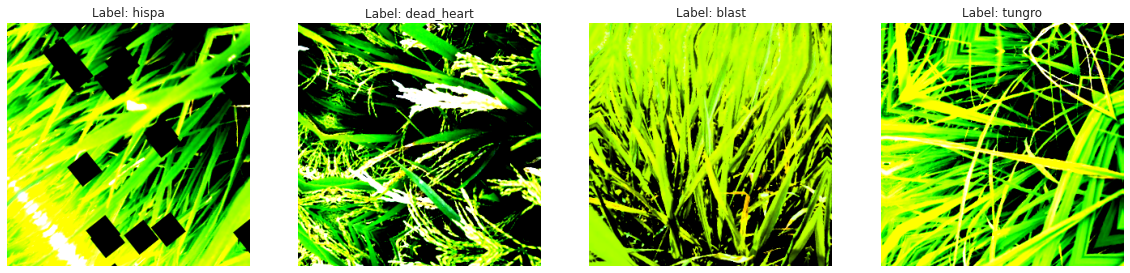

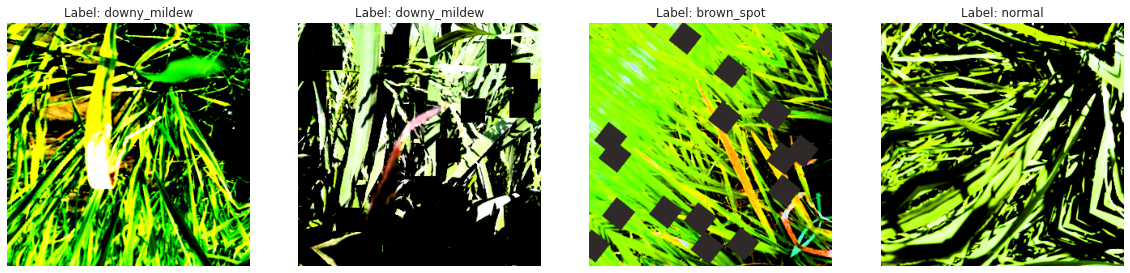

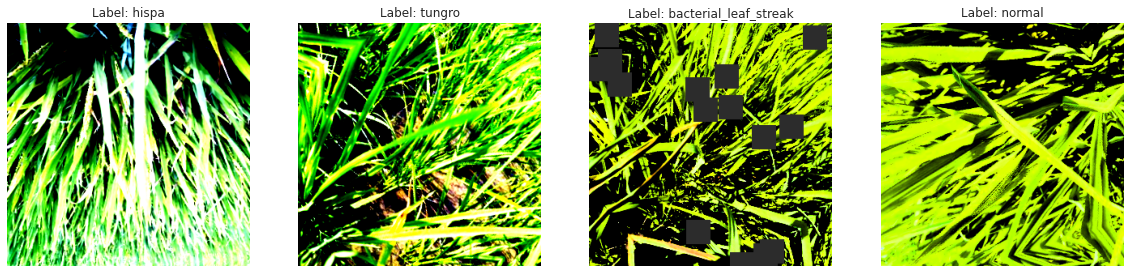

In [18]:
for i in range(3):
    show_image(inline=4)

In [19]:
del X_train, y_train, train_dataset

# Scheduler

`torch.optim.lr_scheduler` provides several methods to adjust the learning rate based on the number of epochs. It is important to adjust the learning rate as we go because it might be useful to come out of local saddle points easily and not get trapped in a local minima. Also this makes the learning rate less sensitive and model more stable.

In [20]:
def get_scheduler(optimizer, scheduler_params=params):
    if scheduler_params['scheduler_name'] == 'CosineAnnealingWarmRestarts':
        scheduler = CosineAnnealingWarmRestarts(
            optimizer,
            T_0=scheduler_params['T_0'],
            T_mult=scheduler_params['T_mult'],
            eta_min=scheduler_params['min_lr'],
            last_epoch=-1
        )
    elif scheduler_params['scheduler_name'] == 'OneCycleLR':
        scheduler = OneCycleLR(
            optimizer,
            max_lr=scheduler_params['max_lr'],
            steps_per_epoch=int(((scheduler_params['num_fold']-1) * train_df.shape[0]) / (scheduler_params['num_fold'] * scheduler_params['batch_size'])) + 1,
            epochs=scheduler_params['epochs'],
        )

    elif scheduler_params['scheduler_name'] == 'CosineAnnealingLR':
        scheduler = CosineAnnealingLR(
            optimizer,
            T_max=scheduler_params['T_max'],
            eta_min=scheduler_params['min_lr'],
            last_epoch=-1
        )
    return scheduler

# Metrics

Now let's create some helper functions that will enable us to track certain performance metric (accuracy in this case) during training.

In [21]:
class MetricMonitor:
    def __init__(self, float_precision=3):
        self.float_precision = float_precision
        self.reset()

    def reset(self):
        self.metrics = defaultdict(lambda: {"val": 0, "count": 0, "avg": 0})

    def update(self, metric_name, val):
        metric = self.metrics[metric_name]

        metric["val"] += val
        metric["count"] += 1
        metric["avg"] = metric["val"] / metric["count"]

    def __str__(self):
        return " | ".join(
            [
                "{metric_name}: {avg:.{float_precision}f}".format(
                    metric_name=metric_name, avg=metric["avg"],
                    float_precision=self.float_precision
                )
                for (metric_name, metric) in self.metrics.items()
            ]
        )

In [22]:
def usr_acc_score(output, target):
    y_pred = output.softmax(dim=1).argmax(dim=1).detach().cpu()
    target = target.cpu()
    return accuracy_score(target, y_pred)

In [23]:
def f1(output, target):
    y_pred = output.softmax(dim=1).argmax(dim=1).detach().cpu()
    target = target.cpu()
    return f1_score(target, y_pred, average='weighted')

In [24]:
def precision(output, target):
    y_pred = output.softmax(dim=1).argmax(dim=1).detach().cpu()
    target = target.cpu()
    return precision_score(target, y_pred, average='weighted')

In [25]:
def recall(output, target):
    y_pred = output.softmax(dim=1).argmax(dim=1).detach().cpu()
    target = target.cpu()
    return recall_score(target, y_pred, average='weighted')

In [26]:
def usr_roc_score(output, target):
    y_pred = output.softmax(dim=1).argmax(dim=1).detach().cpu()
    target = target.cpu()
    return roc_auc_score(target, y_pred, average='weighted', multi_class='ovr')

# CNN Model

We will use a simple **EfficientNet B3** model for demonstration purposes. However you can fork this notebook and play with various other pre-trained models and come up with your own observations.  

We will inherit from the nn.Module class to define our model. This is a easy as well as effective way of defining the model as it allows very granular control over the complete NN. We are not using the full capability of it here since it is a tutorial model, but practicing similar definitions will help if/when you decide to play around a little more with the NN layers and functions.  

Also we are using timm for instancing a pre-trained model.  
The complete list of Pytorch pre-trained image models through timm can be found [here](https://rwightman.github.io/pytorch-image-models/)  

In [27]:
class PaddyNet(nn.Module):
    def __init__(self, model_name=params['model'], out_features=params['out_features'], inp_channels=params['inp_channels'],
                 pretrained=params['pretrained']):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained, in_chans=inp_channels)
        out_channels = self.model.conv_stem.out_channels
        kernel_size = self.model.conv_stem.kernel_size
        stride = self.model.conv_stem.stride
        padding = self.model.conv_stem.padding
        bias = self.model.conv_stem.bias
        self.model.conv_stem = nn.Conv2d(inp_channels, out_channels,
                                          kernel_size=kernel_size, stride=stride,
                                          padding=padding, bias=bias)
        n_features = self.model.classifier.in_features
        self.model.classifier = nn.Identity()
        self.dropout = nn.Dropout(params['dropout'])
        self.fc = nn.Linear(n_features, out_features)
    
    def forward(self, image):
        embeddings = self.model(image)
        x = self.dropout(embeddings)
        output = self.fc(x)
        return output

# Train and Validation Functions

## 1. Train Function

In [28]:
def train_fn(train_loader, model, criterion, optimizer, epoch, params, scheduler=None, scaler=None):
    metric_monitor = MetricMonitor()
    model.train()
    stream = tqdm(train_loader)
    
    for i, (images, target) in enumerate(stream, start=1):
        if params['mixup']:
            images, target_a, target_b, lam = mixup_data(images, target, params)
            images = images.to(params['device'])
            target_a = target_a.to(params['device'])
            target_b = target_b.to(params['device'])
        else:
            images = images.to(params['device'], non_blocking=True)
            target = target.to(params['device'], non_blocking=True)
            
        if params['fp16']:
            with torch.cuda.amp.autocast():
                output = model(images)
                if params['mixup']:
                    loss = mixup_criterion(criterion, output, target_a, target_b, lam)
                else:
                    loss = criterion(output, target)
        else:
            output = model(images)
            if params['mixup']:
                loss = mixup_criterion(criterion, output, target_a, target_b, lam)
            else:
                loss = criterion(output, target)

        metric_monitor.update('Loss', loss.item())
        f1_batch = f1(output, target)
        metric_monitor.update('F1', f1_batch)
        precision_batch = precision(output, target)
        metric_monitor.update('Precision', precision_batch)
        recall_batch = recall(output, target)
        metric_monitor.update('Recall', recall_batch)
        acc_batch = usr_acc_score(output, target)
        metric_monitor.update('Accuracy', acc_batch)

        if params['fp16']:
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            optimizer.step()
            
        if scheduler is not None:
            scheduler.step()
        
        optimizer.zero_grad()
        stream.set_description(f"Epoch: {epoch:02}. Train. {metric_monitor}")

## 2. Validate Function

In [29]:
def validate_fn(val_loader, model, criterion, epoch, params):
    metric_monitor = MetricMonitor()
    model.eval()
    stream = tqdm(val_loader)
    final_targets = []
    final_outputs = []
    with torch.no_grad():
        for i, (images, target) in enumerate(stream, start=1):
            images = images.to(params['device'], non_blocking=True)
            target = target.to(params['device'], non_blocking=True)
            output = model(images)
            loss = criterion(output, target)
            metric_monitor.update('Loss', loss.item())
            f1_batch = f1(output, target)
            metric_monitor.update('F1', f1_batch)
            precision_batch = precision(output, target)
            metric_monitor.update('Precision', precision_batch)
            recall_batch = recall(output, target)
            metric_monitor.update('Recall', recall_batch)
            acc_batch = usr_acc_score(output, target)
            metric_monitor.update('Accuracy', acc_batch)
            stream.set_description(f"Epoch: {epoch:02}. Valid. {metric_monitor}")
            
            targets = target.detach().cpu().numpy().tolist()
            outputs = output.softmax(dim=1).argmax(dim=1).detach().cpu().numpy().tolist()
            
            final_targets.extend(targets)
            final_outputs.extend(outputs)
    return final_outputs, final_targets

# Run

We will train separate models for each validation fold and use all of them as an ensemble for the final predictions.

In [30]:
best_models_of_each_fold = []
accuracy_tracker = []

In [31]:
for fold in range(params['num_fold']):
    print(''.join(['#']*51))
    print(f"{''.join(['=']*15)} TRAINING FOLD: {fold+1}/{train_df['kfold'].nunique()} {''.join(['=']*15)}")
    # Data Split to train and Validation
    train = train_df[train_df['kfold'] != fold]
    valid = train_df[train_df['kfold'] == fold]
    
    X_train = train['image_path']
    y_train = train['label_enc']
    X_valid = valid['image_path']
    y_valid = valid['label_enc']
    
    # Pytorch Dataset Creation
    train_dataset = PaddyDataset(
        images_filepaths=X_train.values,
        targets=y_train.values,
        transform=get_train_transforms()
    )

    valid_dataset = PaddyDataset(
        images_filepaths=X_valid.values,
        targets=y_valid.values,
        transform=get_valid_transforms()
    )
    
    # Pytorch Dataloader creation
    train_loader = DataLoader(
        train_dataset, batch_size=params['batch_size'], shuffle=True,
        num_workers=params['num_workers'], pin_memory=True
        )

    val_loader = DataLoader(
        valid_dataset, batch_size=params['batch_size'], shuffle=False,
        num_workers=params['num_workers'], pin_memory=True
        )
    
    # Model, cost function and optimizer instancing
    model = PaddyNet()
    model = model.to(params['device'])
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=params['lr'],
                                  weight_decay=params['weight_decay'],
                                  amsgrad=False)
    scheduler = get_scheduler(optimizer)

    if params['fp16']:
        scaler = torch.cuda.amp.GradScaler()
    else:
        scaler = None
    
    # Training and Validation Loop
    best_accracy = -np.inf
    best_epoch = np.inf
    best_model_name = None
    for epoch in range(1, params['epochs'] + 1):
        train_fn(train_loader, model, criterion, optimizer, epoch, params, scheduler, scaler)
        predictions, valid_targets = validate_fn(val_loader, model, criterion, epoch, params)
        accuracy = round(accuracy_score(valid_targets, predictions), 3)
        if accuracy > best_accracy:
            best_accracy = accuracy
            best_epoch = epoch
            if best_model_name is not None:
                os.remove(best_model_name)
            torch.save(model.state_dict(), f"{params['model']}_{epoch}_epoch_f{fold+1}_{accuracy}_accuracy.pth")
            best_model_name = f"{params['model']}_{epoch}_epoch_f{fold+1}_{accuracy}_accuracy.pth"

    # Print summary of this fold
    print('')
    print(f'The best Accuracy: {best_accracy} for fold {fold+1} was achieved on epoch: {best_epoch}.')
    print(f'The Best saved model is: {best_model_name}')
    best_models_of_each_fold.append(best_model_name)
    accuracy_tracker.append(best_accracy)
    print(''.join(['#']*50))
    del model
    gc.collect()
    torch.cuda.empty_cache()

print('')
print(f'Average Accuracy of all folds: {round(np.mean(accuracy_tracker), 4)}')

###################################################
=============== TRAINING FOLD: 1/5 ===============


Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/efficientnet_b3_ra2-cf984f9c.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b3_ra2-cf984f9c.pth


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]


The best Accuracy: 0.96 for fold 1 was achieved on epoch: 20.
The Best saved model is: efficientnet_b3_20_epoch_f1_0.96_accuracy.pth
##################################################
###################################################
=============== TRAINING FOLD: 2/5 ===============


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]


The best Accuracy: 0.966 for fold 2 was achieved on epoch: 13.
The Best saved model is: efficientnet_b3_13_epoch_f2_0.966_accuracy.pth
##################################################
###################################################
=============== TRAINING FOLD: 3/5 ===============


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]


The best Accuracy: 0.966 for fold 3 was achieved on epoch: 20.
The Best saved model is: efficientnet_b3_20_epoch_f3_0.966_accuracy.pth
##################################################
###################################################
=============== TRAINING FOLD: 4/5 ===============


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]


The best Accuracy: 0.972 for fold 4 was achieved on epoch: 17.
The Best saved model is: efficientnet_b3_17_epoch_f4_0.972_accuracy.pth
##################################################
###################################################
=============== TRAINING FOLD: 5/5 ===============


  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]


The best Accuracy: 0.969 for fold 5 was achieved on epoch: 20.
The Best saved model is: efficientnet_b3_20_epoch_f5_0.969_accuracy.pth
##################################################

Average Accuracy of all folds: 0.9666


In [32]:
for i, name in enumerate(best_models_of_each_fold):
    print(f'Best model of fold {i+1}: {name}')

Best model of fold 1: efficientnet_b3_20_epoch_f1_0.96_accuracy.pth
Best model of fold 2: efficientnet_b3_13_epoch_f2_0.966_accuracy.pth
Best model of fold 3: efficientnet_b3_20_epoch_f3_0.966_accuracy.pth
Best model of fold 4: efficientnet_b3_17_epoch_f4_0.972_accuracy.pth
Best model of fold 5: efficientnet_b3_20_epoch_f5_0.969_accuracy.pth


This is a simple starter kernel on implementation of Transfer Learning using Pytorch.  
Pytorch has many SOTA Image models which you can try out using the guidelines in this notebook.  

I hope you have learnt something from this notebook. Please feel free to ask below in case of any doubt. I will try my best to answer your questions and make you understand the concepts.  

**If you liked this notebook and use parts of it in you code, please upvote this kernel. It keeps me inspired to come-up with such beginner friendly tutorial type notebooks like this one and share it with the community.**

Thanks and happy kaggling!